In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2022-01-09.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.isocalendar().week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Year", cumul_ams["Date_of_report"].dt.isocalendar().year) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

/Users/zeddee/src/nl-covid19-eda/.direnv/python-3.9.2/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Year","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 109 to 240518
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      659 non-null    datetime64[ns]
 1   Day                 659 non-null    object        
 2   Week                659 non-null    UInt32        
 3   Year                659 non-null    UInt32        
 4   Daily_delta         659 non-null    int64         
 5   Total_reported      659 non-null    int64         
 6   Deceased            659 non-null    int64         
 7   Deceased_delta      659 non-null    int64         
 8   Hospital_admission  659 non-null    int64         
 9   Hospital_delta      659 non-null    int64         
dtypes: UInt32(2), datetime64[ns](1), int64(6), object(1)
memory usage: 52.8+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Year,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
237242,2021-12-22,Wednesday,51,2021,814,157137,944,1,2371,4
237606,2021-12-23,Thursday,51,2021,750,157887,945,1,2372,1
237970,2021-12-24,Friday,51,2021,850,158737,945,0,2373,1
238334,2021-12-25,Saturday,51,2021,753,159490,947,2,2374,1
238698,2021-12-26,Sunday,51,2021,886,160376,948,1,2381,7
239062,2021-12-27,Monday,52,2021,628,161004,950,2,2387,6
239426,2021-12-28,Tuesday,52,2021,604,161608,951,1,2389,2
239790,2021-12-29,Wednesday,52,2021,1046,162654,952,1,2393,4
240154,2021-12-30,Thursday,52,2021,914,163568,954,2,2397,4
240518,2021-12-31,Friday,52,2021,1380,164948,959,5,2400,3


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
240518,2021-12-31,52,1380,164948,3
177546,2021-07-11,27,1339,94402,2
179002,2021-07-15,28,1277,99061,3
178638,2021-07-14,28,1215,97784,1
177910,2021-07-12,28,1159,95561,1
230326,2021-12-03,48,1130,144808,2
179730,2021-07-17,28,1126,101309,3
179366,2021-07-16,28,1122,100183,0
225594,2021-11-20,46,1071,134103,8
239790,2021-12-29,52,1046,162654,4


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3, year:int=2021):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):

        df = df[df["Year"] == year]
        today = df["Date_of_report"].max()
        this_week_number = pd.Timestamp(today).week - week
        # we previously tried to get the week number by getting
        # the max value of df["Week"] (the week column),
        # but that breaks when we move from one year to the next
        # now, get week from the latest report.
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

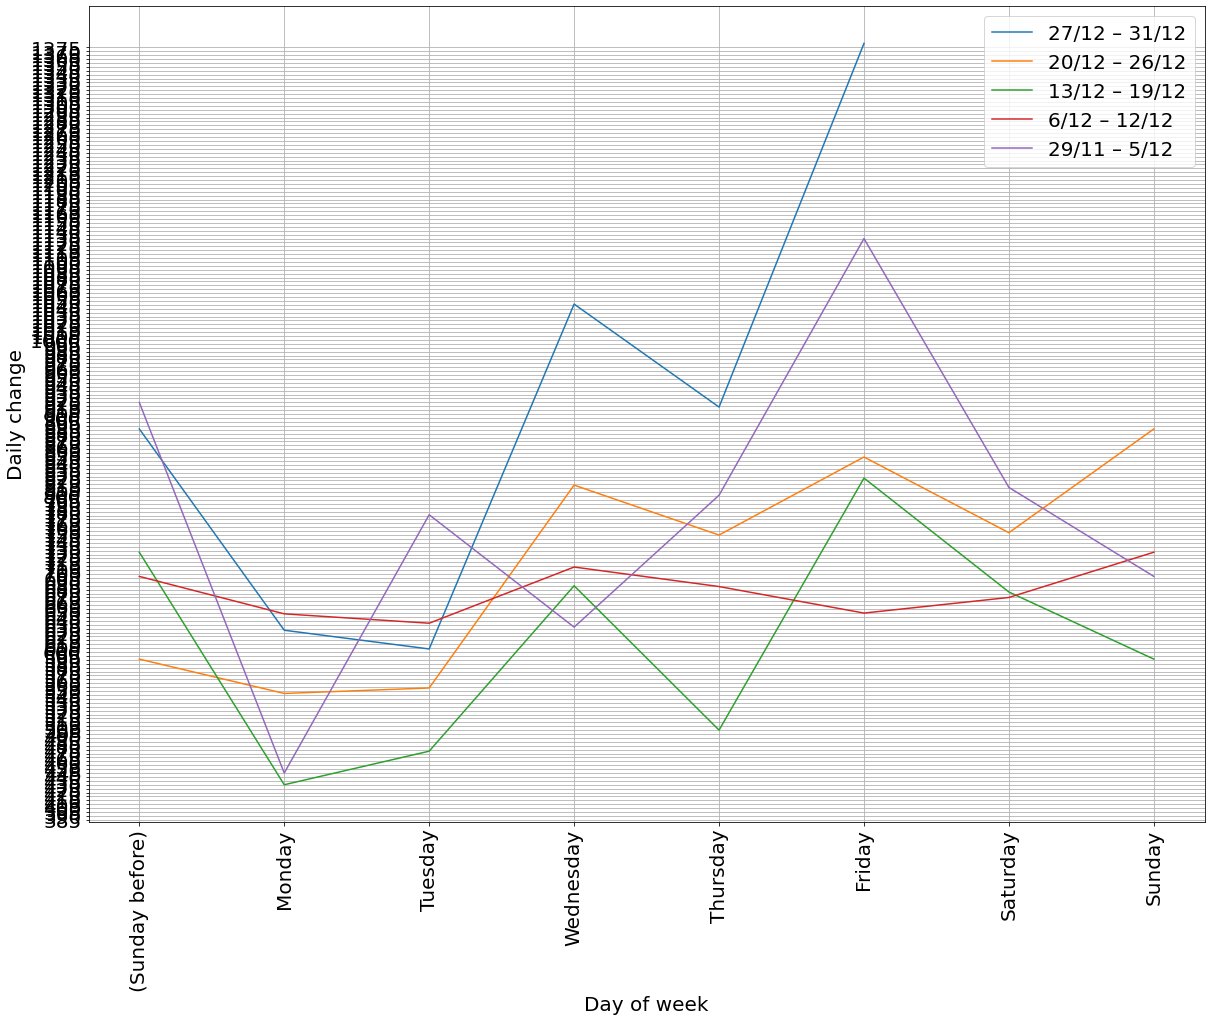

,Date_of_report,Week,Daily_delta,Total_reported
238334,2021-12-25,51,753,159490
238698,2021-12-26,51,886,160376
239062,2021-12-27,52,628,161004
239426,2021-12-28,52,604,161608
239790,2021-12-29,52,1046,162654
240154,2021-12-30,52,914,163568
240518,2021-12-31,52,1380,164948


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        this_week = pd.Timestamp(df["Date_of_report"].max()).week
        if this_week < week:
            print(f"Week no. {this_week - week} does not exist.")
            continue

        this_week_num = this_week - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

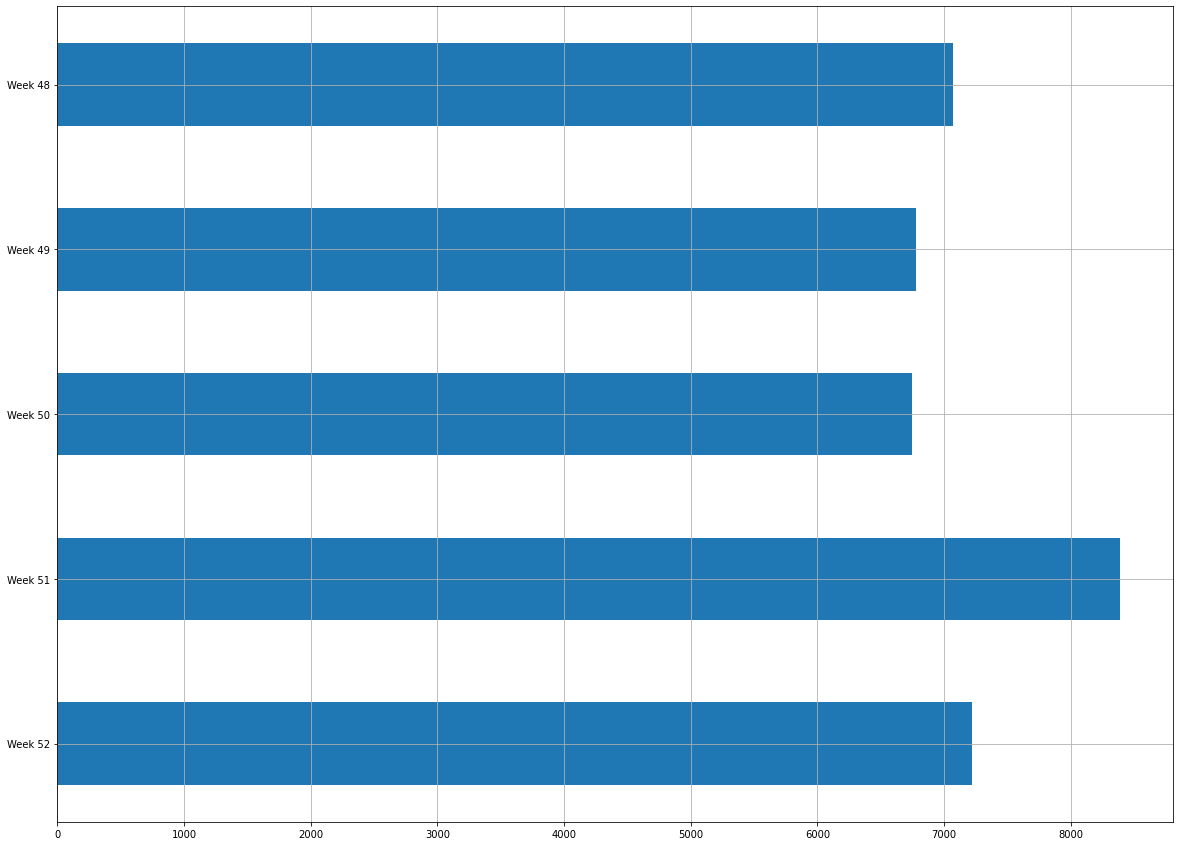

{'Week 48': 7074,
 'Week 49': 6780,
 'Week 50': 6747,
 'Week 51': 8390,
 'Week 52': 7223}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

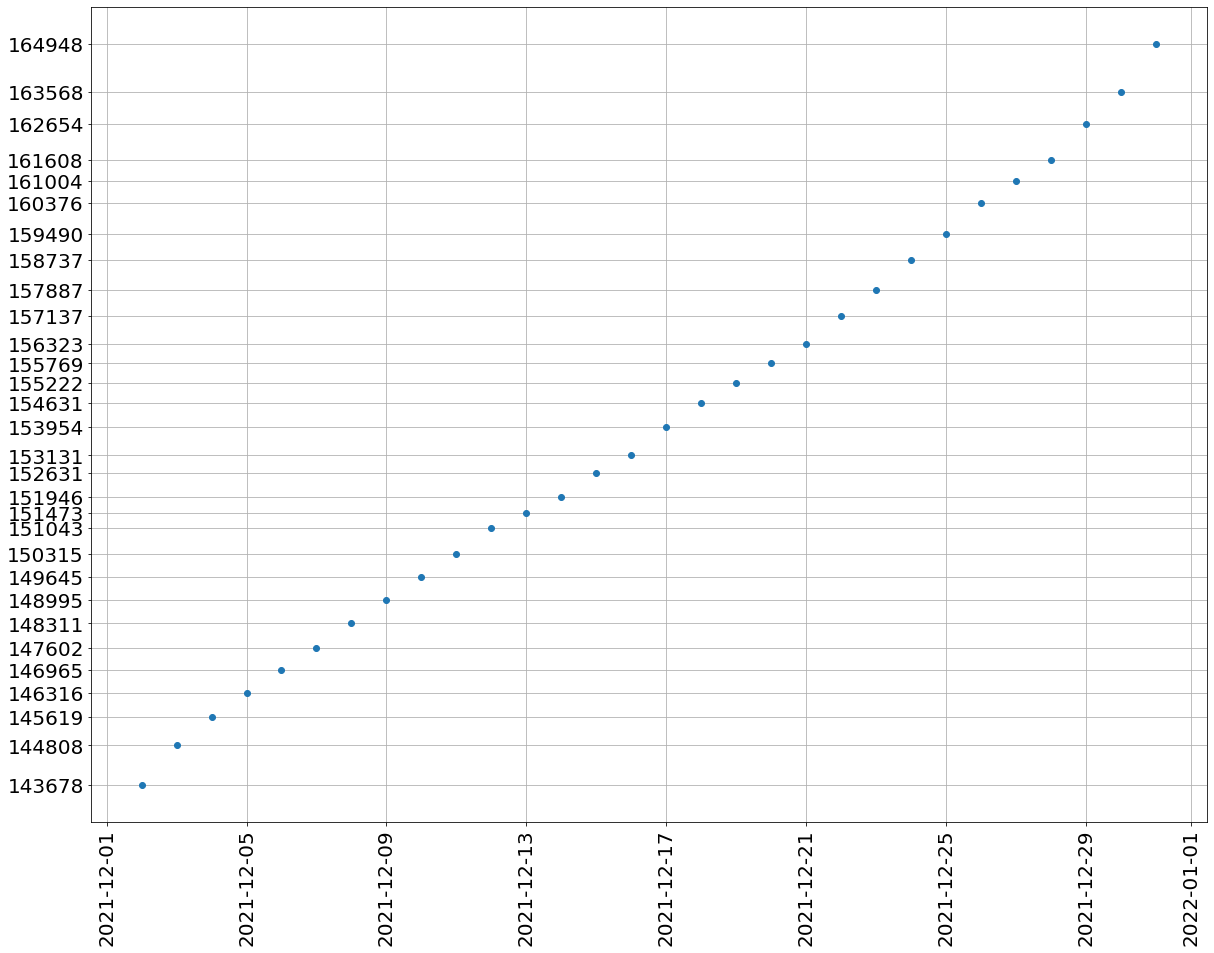

       Date_of_report  Total_reported
229962     2021-12-02          143678
230326     2021-12-03          144808
230690     2021-12-04          145619
231054     2021-12-05          146316
231418     2021-12-06          146965
231782     2021-12-07          147602
232146     2021-12-08          148311
232510     2021-12-09          148995
232874     2021-12-10          149645
233238     2021-12-11          150315
233602     2021-12-12          151043
233966     2021-12-13          151473
234330     2021-12-14          151946
234694     2021-12-15          152631
235058     2021-12-16          153131
235422     2021-12-17          153954
235786     2021-12-18          154631
236150     2021-12-19          155222
236514     2021-12-20          155769
236878     2021-12-21          156323
237242     2021-12-22          157137
237606     2021-12-23          157887
237970     2021-12-24          158737
238334     2021-12-25          159490
238698     2021-12-26          160376
239062     2

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

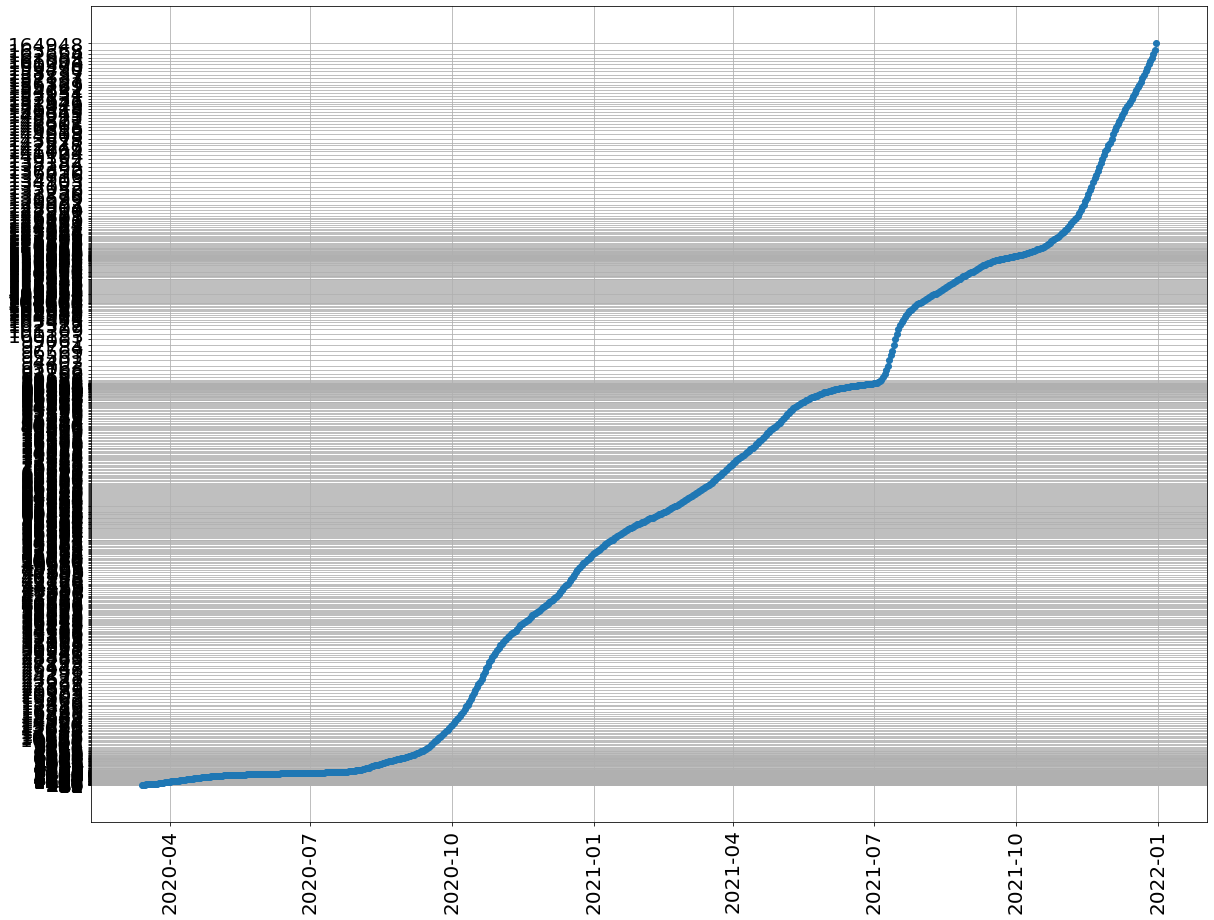

       Date_of_report  Total_reported
476        2020-03-14              31
843        2020-03-15              31
1210       2020-03-16              39
1577       2020-03-17              56
1944       2020-03-18              61
...               ...             ...
239062     2021-12-27          161004
239426     2021-12-28          161608
239790     2021-12-29          162654
240154     2021-12-30          163568
240518     2021-12-31          164948

[658 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

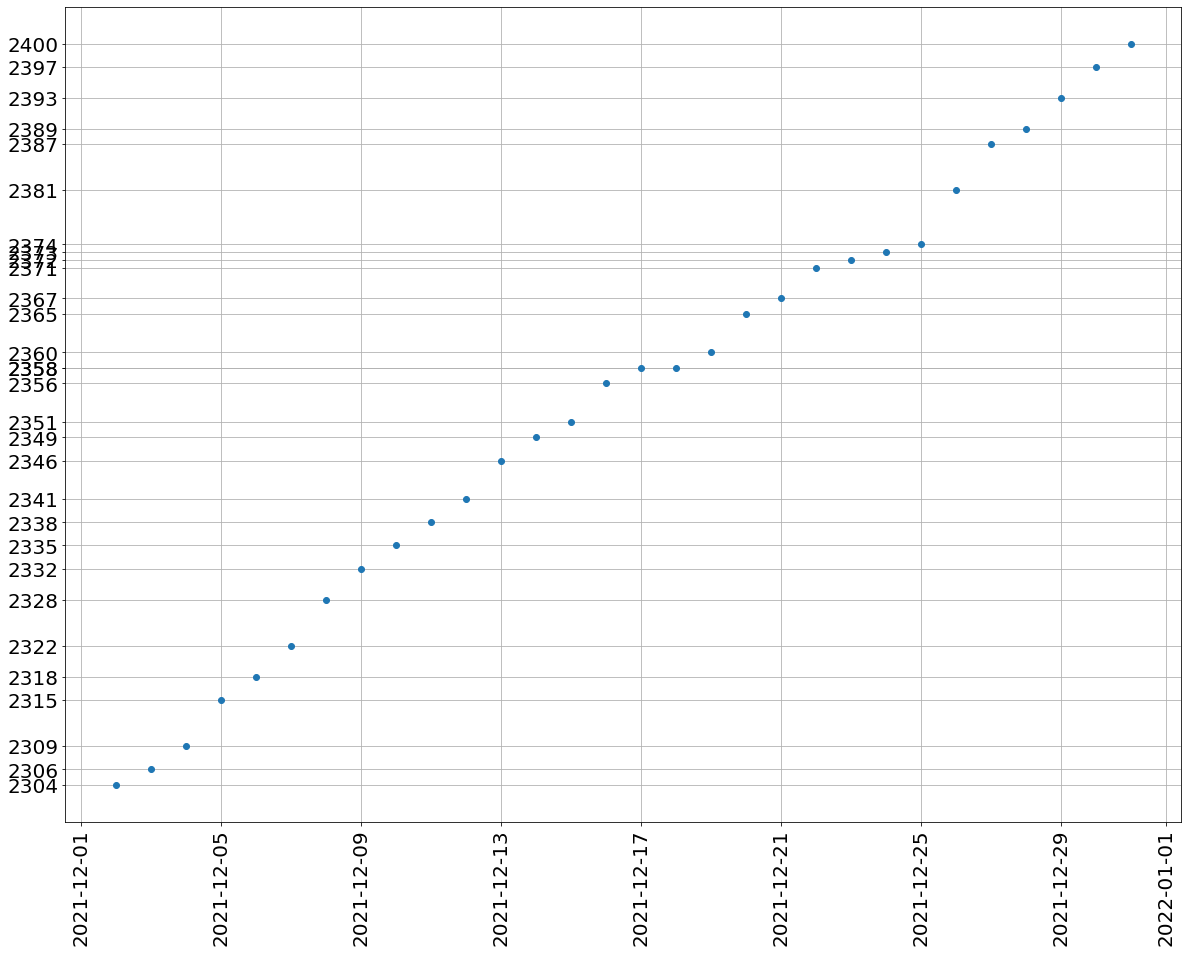

       Date_of_report  Hospital_admission
229962     2021-12-02                2304
230326     2021-12-03                2306
230690     2021-12-04                2309
231054     2021-12-05                2315
231418     2021-12-06                2318
231782     2021-12-07                2322
232146     2021-12-08                2328
232510     2021-12-09                2332
232874     2021-12-10                2335
233238     2021-12-11                2338
233602     2021-12-12                2341
233966     2021-12-13                2346
234330     2021-12-14                2349
234694     2021-12-15                2351
235058     2021-12-16                2356
235422     2021-12-17                2358
235786     2021-12-18                2358
236150     2021-12-19                2360
236514     2021-12-20                2365
236878     2021-12-21                2367
237242     2021-12-22                2371
237606     2021-12-23                2372
237970     2021-12-24             

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

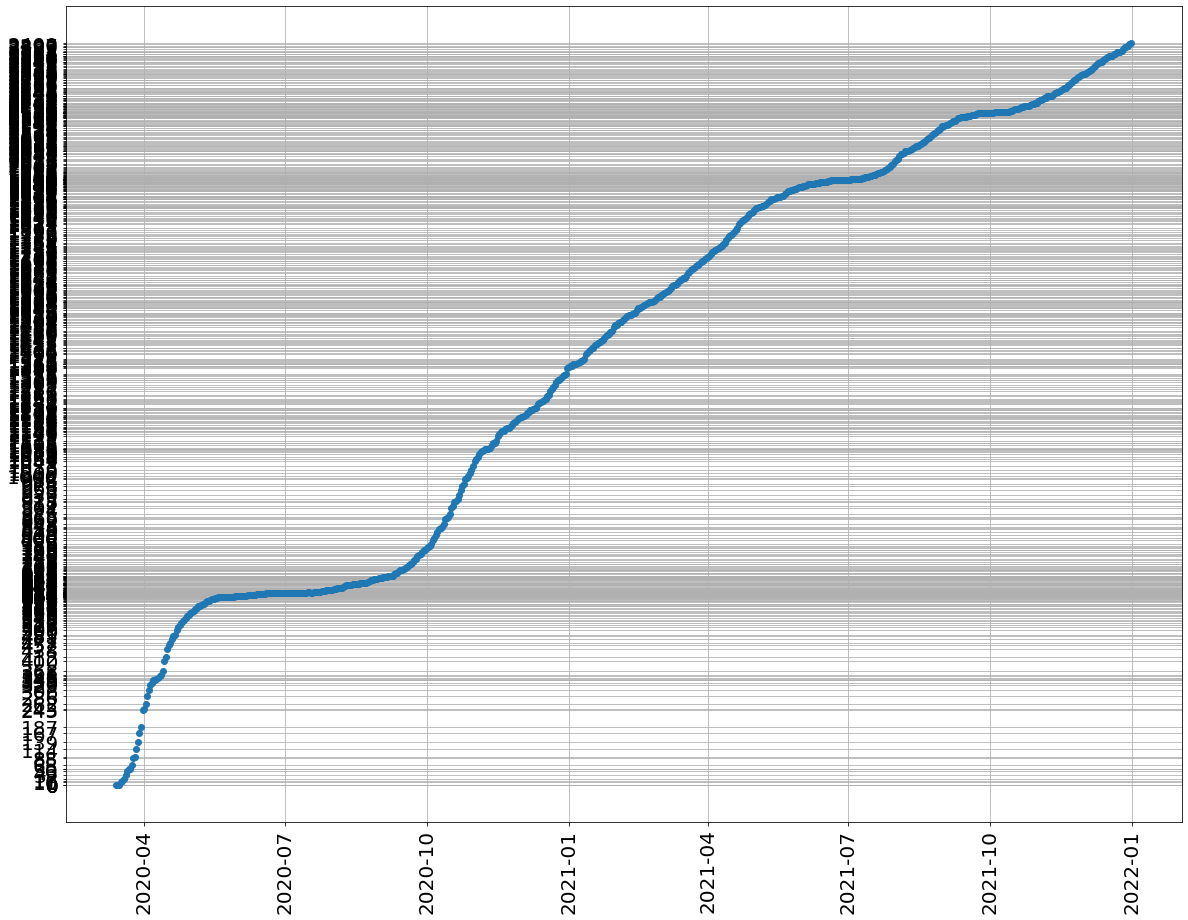

       Date_of_report  Hospital_admission
476        2020-03-14                   0
843        2020-03-15                   0
1210       2020-03-16                   0
1577       2020-03-17                  10
1944       2020-03-18                  11
...               ...                 ...
239062     2021-12-27                2387
239426     2021-12-28                2389
239790     2021-12-29                2393
240154     2021-12-30                2397
240518     2021-12-31                2400

[658 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

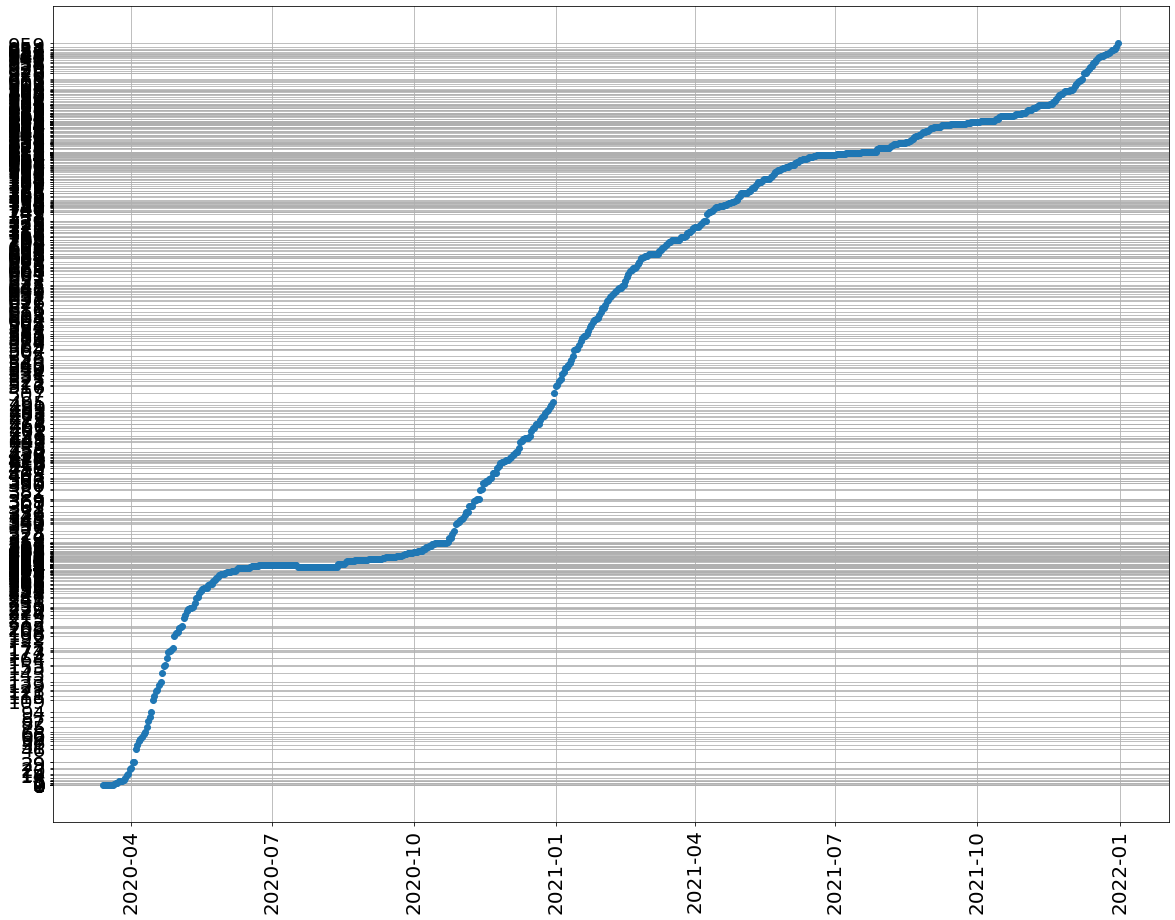

       Date_of_report  Deceased
476        2020-03-14         0
843        2020-03-15         0
1210       2020-03-16         0
1577       2020-03-17         0
1944       2020-03-18         0
...               ...       ...
239062     2021-12-27       950
239426     2021-12-28       951
239790     2021-12-29       952
240154     2021-12-30       954
240518     2021-12-31       959

[658 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")